# ResUnet for segmentation model : trained with Thin Regions Dataset and finetuned with vessel images 


In [2]:
%load_ext autoreload
%autoreload 2

# Functions

In [3]:
def plot_examples_vessels(ds, models, model_names, n=4, figsize=(27,5)):
    """Plot some example segmentations"""

    # for model in models:
    #     model.eval()
    #     model.cuda()

    indices = random.sample(range(len(ds)), n)
    
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        # x = torch.cat([x] * 3, dim=0) # repeat 3 times to get 3 channels
       
        y_preds = []
        iou_scores = []
        with torch.no_grad():
            for model in models:
                y_pred = model(x[None].cuda())[0].cpu()
                y_pred = torch.max(y_pred, dim=0)[1]
                y_preds.append(y_pred)
                # Calculate IoU
                iou_score = perf_funcs.segmentation_accuracy(y_pred, y[None], meas = 'iou')                
                iou_scores.append(iou_score)
        
        # Get the first channel of the image        
        x = x[0]       
        
        
        plt.figure(figsize=figsize)
        plt.subplot(1, len(models) + 3, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, len(models) + 3, 2)
        plt.imshow(x, 'gray')
        plt.title('Cropped and Augmented image')
        plt.subplot(1, len(models) + 3, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        
        # Plot predictions and IoU
        print(iou_scores)
        
        for i, y_pred, iou_score in zip(range(len(y_preds)), y_preds, iou_scores):
            plt.subplot(1, len(models) + 3, i + 4)
            plt.imshow(y_pred, 'gray')
            plt.title(f'{model_names[i]} \n IoU: {iou_score:.4f}')
    
        
        plt.show()

In [4]:
def get_image_label_prediction(model, dataset, img_idx):
    """
    Obtains the original image, equalized image, label, filename, and prediction for a given image index.

    Parameters
    ----------
        * model (torch.nn.Module): The model used for prediction.
        * dataset (torch.utils.data.Dataset): The dataset containing the images.
        * img_idx (int): The index of the image to retrieve.

    Returns
    -------
        * img_or (numpy.ndarray): The original image.
        * img_equalized (numpy.ndarray): The equalized image.
        * label (int): The label of the image.
        * filename (str): The filename of the image.
        * pre/d (torch.Tensor): The prediction of the model for the image.
    """
    # Get original image from dataset
    img_or, _ = dataset.get_item(img_idx)
    img_or = np.array(img_or)
    # Get equalized image and its label
    img_equalized, label = dataset[img_idx]
    # Get filename
    filename = dataset.img_file_paths[img_idx].stem

    # Prediction
    with torch.no_grad():
        pred = model(img_equalized[None].to('cuda')).cpu()

    return img_or, img_equalized, label, filename, pred

def get_inference_iou(model, dataset):
    """
    Calculates the Intersection over Union (IoU) for each image in the dataset.

    Parameters
    ----------
        * model (object): The trained model used for prediction.
        * dataset (object): The dataset containing the images and labels.

    Returns
    -------
        * prediction_summary (DataFrame): A DataFrame containing the image index and the corresponding IoU.
    """
    # Define columns names
    columns_ = ['img_idx', 'prediction_iou']
    # Create dataframe
    prediction_summary = pd.DataFrame(columns = columns_)
    # Get dataset len
    dataset_len = len(dataset)

    for img_idx in range(dataset_len):

        img_or, img_equalized, label, filename, pred = get_image_label_prediction(model, dataset, img_idx)
        iou = perf_funcs.segmentation_accuracy(pred, label[None], meas = 'iou')

        # A dictionary to store the data
        results_dict = {
            "img_idx" : img_idx,
            "prediction_iou" : iou.numpy(),
        }

        # Convert the dict to dataframe
        df_result = pd.DataFrame([results_dict])
        # Concact df_result with prediction_summary to append a new row
        prediction_summary = pd.concat([prediction_summary, df_result])

    # Reset indexes
    prediction_summary.reset_index(drop = True, inplace = True)

    return prediction_summary




In [5]:
def load_model_with_checkpoint(checkpoint_path, model):
    """
    Loads a PyTorch model with a checkpoint.

    Parameters
    ----------
        * checkpoint_path (str): The path to the checkpoint file.
        * model (nn.Module): The PyTorch model to load the checkpoint into.

    Returns
    -------
        * nn.Module: The PyTorch model with the loaded checkpoint.
    """
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))

    # Extract the state dictionary from the checkpoint
    state_dict = checkpoint['state_dict']

    # Create a new dictionary to store the model state
    new_state_dict = {}

    # Iterate over each item in the state dictionary
    for k, v in state_dict.items():
        # If the item's key starts with 'model.', remove this prefix from the key
        # and add the item to the new state dictionary
        if k.startswith('model.'):
            new_state_dict[k[6:]] = v

    # Load the model state from the new state dictionary
    model.load_state_dict(new_state_dict)

    # Put the model in evaluation mode
    model.eval()
    model.cuda()

    return model

# Training

In [6]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import torch

import train_lightning as train_lightning
import dataset_vessel as dataset
import torchtrainer

import torchtrainer.models.resunet as resunet
from torchtrainer import perf_funcs

import pandas as pd
import numpy as np
import plotly.express as px

import segmentation_models_pytorch as smp
import dataset_vessel as dataset



## Define parameters


In [8]:
%%time


img_path = '../../datasets/blood_vessels/VessMAP/images'
label_path = '../../datasets/blood_vessels/VessMAP/annotator1/labels'
pretrained_model_path = '../02_models_evaluation/models/resUnet_l_3_3_3_3_c_16_32_64_128_ThinObjectDataset4k_data-aug_ep_100_lr_0.01_bs_8_FP32_batch-norm/best_val_loss-epoch=97-val_loss=0.23.ckpt'


params = {
    # Dataset
    'img_dir': Path(img_path),
    'label_dir': Path(label_path),
    'train_val_split': 0.2,
    # Model
    'model_layers': (3,3,3,3),
    'model_channels': (16,32,64,128),
    'model_type': 'unet',
    # Training
    'epochs': 300,
    'lr': 100e-5,
    'batch_size_train': 8, 
    'batch_size_valid': 20, 
    'momentum': 0.9,
    'weight_decay': 0.01, # Peso de regularização ex: 0.01 
    'seed': 12,
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,
    # weights for the classes to balance the loss function. 
    # In the left is the weight for class 0 (background) and in the right is the weight for class 1 (object).
    'class_weights': (0.26, 0.74), 
    # Type of normalization. Options: 'batch_norm', 'group_norm'
    'normalization_layer': 'batch_norm',
    # Efficiency
    'device': 'cuda',
    'num_workers': 6,  # 3 is a good compromise
    'use_amp': False,  # Automatic mixed precision. True means that the model will use half precision (FP16) during training. 
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': 'logs',
    'experiment':'resUnet_l_3_3_3_3_c_16_32_64_128_ThinObjectDataset4k_data-aug_finetuned_with_vessels_ep_300_lr_100e-5_bs_8_FP32_batch-norm',
    'save_every':1,
    'save_best':True,
    # Other
    'resume': False,
    'finetune' : True,
    'meta': None, 
    # The name of the checkpoint file you want to load and resume training or the path for the checkpoint file you want to use for tuning.
    'checkpoint_to_resume' : pretrained_model_path
}



CPU times: user 19 µs, sys: 5 µs, total: 24 µs
Wall time: 26 µs


## Get image statistics

In [9]:
ds_train, ds_valid = dataset.create_datasets(img_path, label_path, train_val_split=0.01)
x, y = next(iter(ds_train))
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [10]:
# Get image statistics
dataset.get_statistics(ds_train)

Mean: -0.00
Std: 1.00
Percentage of object pixels: 0.26
Percentage of background pixels: 0.74


## Run training

In [11]:
%%time
#Train using pure Pytorch
#logger, ds_train, ds_valid, model = train_pytorch.run(params)
#Train using Pytorch Lightning
trainer, ds_train, ds_valid, model = train_lightning.run(params)
logger = trainer.loggers[1]

Seed set to 12


Finetuning from checkpoint ../02_models_evaluation/models/resUnet_l_3_3_3_3_c_16_32_64_128_ThinObjectDataset4k_data-aug_ep_100_lr_0.01_bs_8_FP32_batch-norm/best_val_loss-epoch=97-val_loss=0.23.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | loss_func | CrossEntropyLoss | 0     
1 | model     | ResUNet          | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.078     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


CPU times: user 2min 32s, sys: 19.6 s, total: 2min 51s
Wall time: 3min 14s


# View results

## Training logs

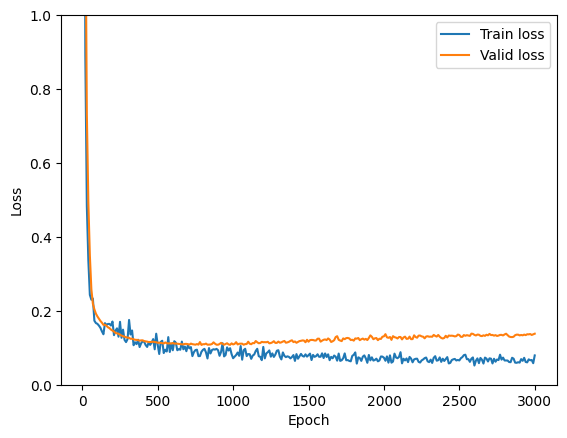

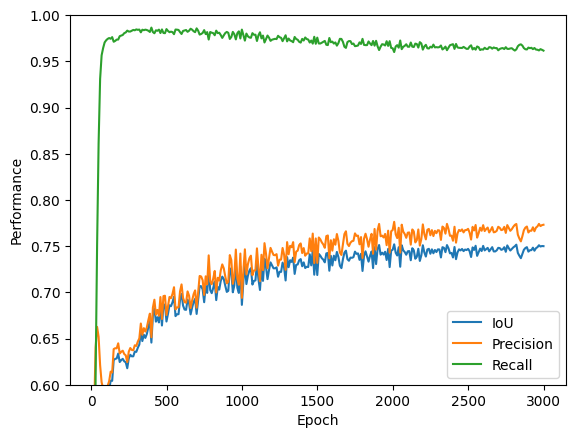

In [12]:
# Plot results
def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 'rec']]
        train_loss, valid_loss, iou, prec, rec = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0.6, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')
    
plot_metrics(logger, type='lt')

## Visual Evaluation

### Instantiate model

In [14]:
# ResUnet
model_layers =  (3,3,3,3) 
model_channels =  (16,32,64,128)
model = torchtrainer.models.resunet.ResUNet(model_layers, model_channels,  in_channels=3)

### Load model weights

In [15]:
# Last checkpoint
resUnet_finetuned_e300_path = 'logs/resUnet_l_3_3_3_3_c_16_32_64_128_ThinObjectDataset4k_data-aug_finetuned_with_vessels_ep_300_lr_100e-5_bs_8_FP32_batch-norm/checkpoints/epoch=299-step=3000.ckpt'
resUnet_finetuned_e300_ckp = load_model_with_checkpoint(resUnet_finetuned_e300_path, model)

# Best checkpoint
resUnet_finetuned_e78_path = 'logs/resUnet_l_3_3_3_3_c_16_32_64_128_ThinObjectDataset4k_data-aug_finetuned_with_vessels_ep_300_lr_100e-5_bs_8_FP32_batch-norm/checkpoints/best_val_loss-epoch=78-val_loss=0.11.ckpt'
resUnet_finetuned_e78_ckp = load_model_with_checkpoint(resUnet_finetuned_e78_path, model)

### Load dataset

In [16]:
vessel_highres_imgs = '../../datasets/blood_vessels/vessel_crop/images'
vessel_highres_labels = '../../datasets/blood_vessels/vessel_crop/labels'

In [17]:
_, vessel_highres_ds = dataset.create_datasets(
    img_dir=vessel_highres_imgs,
    label_dir=vessel_highres_labels,
    crop_size=(256,256),
    train_val_split=.99,
    seed=42
)

print("Dataset length:", len(vessel_highres_ds))
print("Image shape:", vessel_highres_ds[0][0].shape)

Dataset length: 99
Image shape: torch.Size([3, 256, 256])


In [18]:
models_list = [
    resUnet_finetuned_e300_ckp,
    resUnet_finetuned_e78_ckp
]

models_names = [
    'resUnet_finetuned_e300',
    'resUnet_finetuned_e78'
]

[tensor(0.0037), tensor(0.0037)]


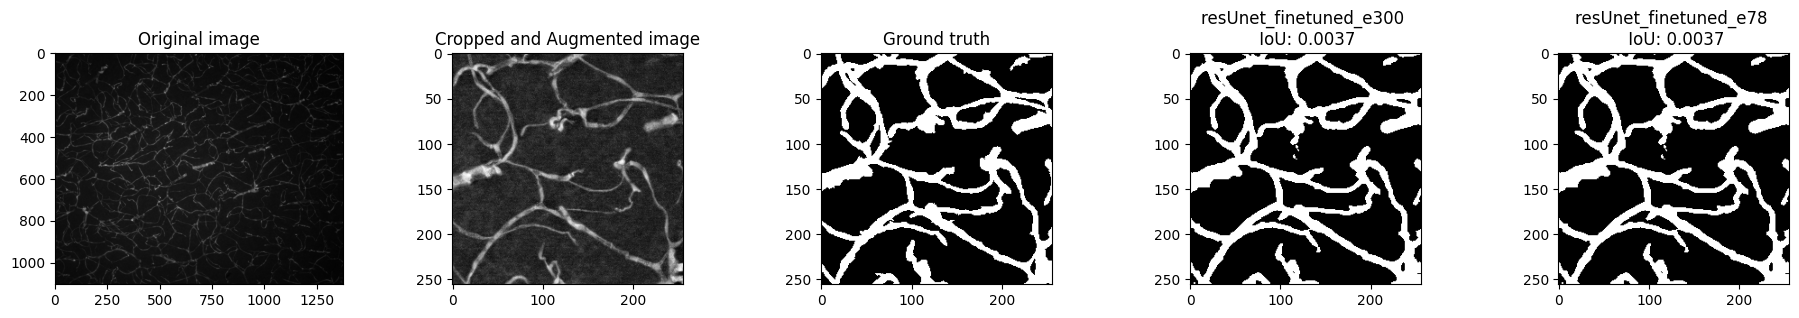

[tensor(0.0216), tensor(0.0216)]


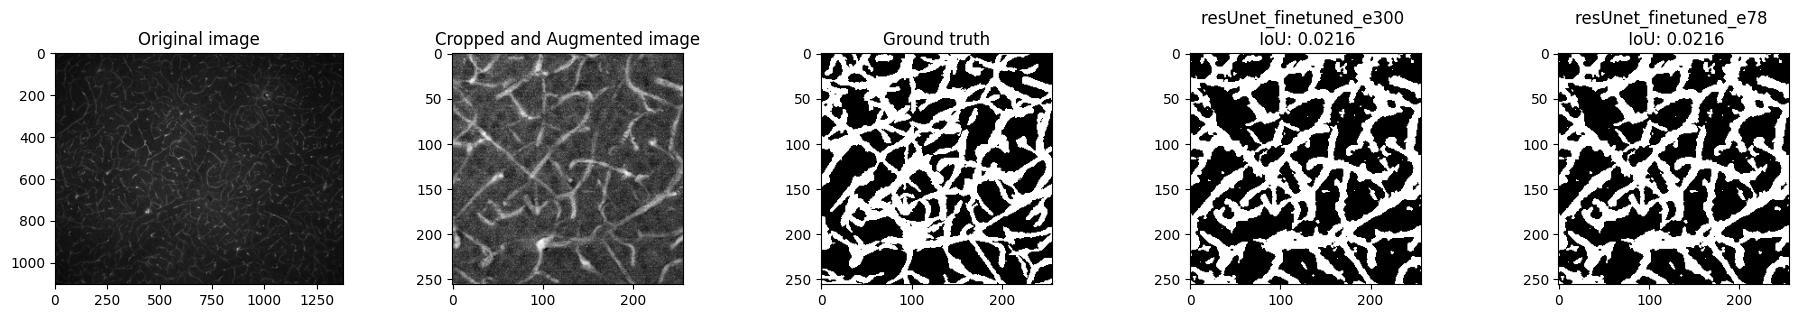

[tensor(0.0672), tensor(0.0672)]


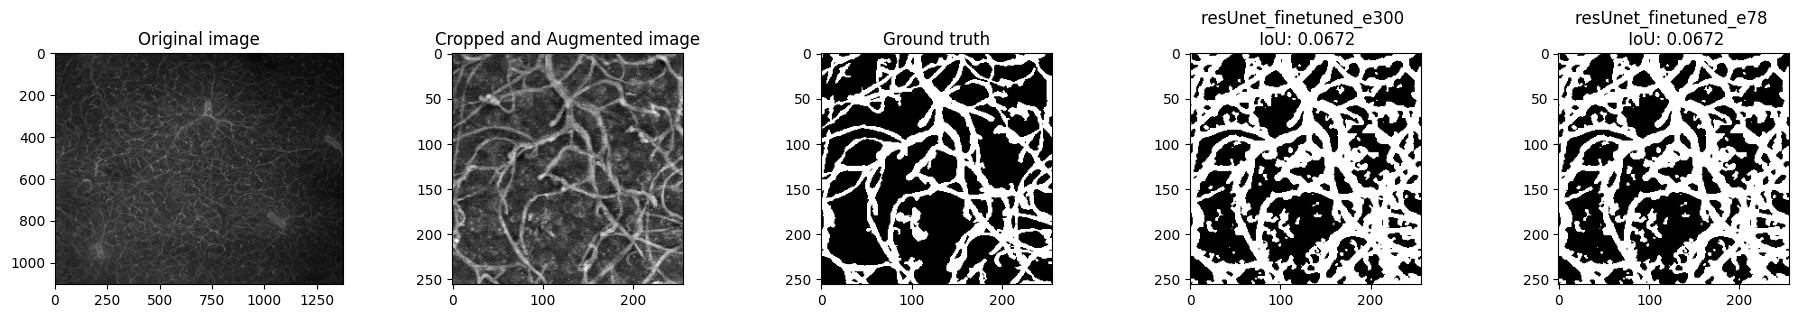

[tensor(0.0035), tensor(0.0035)]


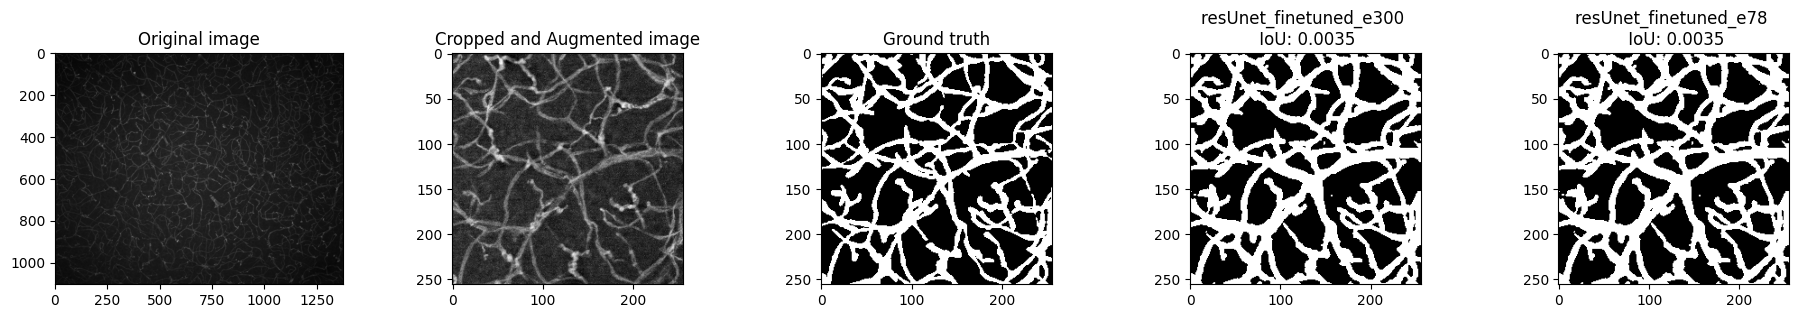

In [26]:
plot_examples_vessels(   
    ds=vessel_highres_ds, 
    models=models_list, 
    model_names=models_names, 
    n=4,
    figsize=(23,3)
)